In [1]:
from transformer_lens import HookedTransformer
import dotenv
dotenv.load_dotenv()
device = "cuda"
model = HookedTransformer.from_pretrained("gpt2")
model = model.to(device)


/mnt/align3_drive/adrianoh/miniconda3/envs/llm-density/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset("stas/openwebtext-10k", split="train", trust_remote_code=True) # Smaller version
tokenizer = AutoTokenizer.from_pretrained("gpt2")
token_dataset = tokenize_and_concatenate(
    dataset=dataset,  # type: ignore
    tokenizer=tokenizer,  # type: ignore
    streaming=True,
    # NOTE: all these have context 128
    max_length=128, #sae.cfg.context_size,
    add_bos_token=True, #sae.cfg.prepend_bos,
)

In [3]:
print(token_dataset.shape)
dataset_size = 500
token_dataset_short = token_dataset[:dataset_size]['tokens']
dataset_length = token_dataset_short.shape[0]
sequence_length = token_dataset_short.shape[1]


(88605, 1)


In [4]:
print(token_dataset_short.shape)
token_dataset_short = token_dataset_short.to(device)

torch.Size([500, 128])


In [5]:
import torch
from transformer_lens.hook_points import HookPoint
hook_name = "blocks.6.hook_resid_pre" # yolo
outs = []
def collect_hook(act, hook: HookPoint):
    outs.append(act.detach().clone())
    return act
batch_size = 50
for i in range(0, token_dataset_short.shape[0], batch_size):
    j = min(i + batch_size, token_dataset_short.shape[0])
    model.run_with_hooks(
        token_dataset_short[i:j],
        return_type=None,
        fwd_hooks=[(hook_name, collect_hook)],
    )
activations = torch.cat(outs, dim=0)
print(activations.shape)

torch.Size([500, 128, 768])


In [6]:
import einops
activations = einops.rearrange(activations, "batch pos d_model -> (batch pos) d_model")

In [7]:
activations.shape

torch.Size([64000, 768])

In [10]:
def calculate_pca_data(activations: torch.Tensor) -> tuple:
    # activations shape: batch x d_model
    assert activations.ndim == 2
    mean = activations.mean(dim=0, keepdim=True)  # 1 x d_model
    centered = activations - mean  # batch x d_model
    cov = torch.matmul(centered.T, centered) / (activations.shape[0] - 1)  # d_model x d_model
    cov_eigvals, cov_eigvecs = torch.linalg.eigh(cov)
    return mean.squeeze(0), cov, cov_eigvals, cov_eigvecs  # Return mean vector and covariance matrix

mean, cov, cov_eigvals, cov_eigvecs = calculate_pca_data(activations)
print("mean.shape=", mean.shape)
print("cov.shape=", cov.shape)
print("cov_eigvals.shape=", cov_eigvals.shape)
print("cov_eigvecs.shape=", cov_eigvecs.shape)

mean.shape= torch.Size([768])
cov.shape= torch.Size([768, 768])
cov_eigvals.shape= torch.Size([768])
cov_eigvecs.shape= torch.Size([768, 768])


In [11]:
import torch.nn as nn
d_model = activations.shape[1]
pca_projector = nn.Linear(d_model, 2).to(device)
# Take the first two rows
pca_projector.weight.data = cov_eigvecs[:2, :]
pca_projector.bias.data = (cov_eigvecs @ mean)[:2]

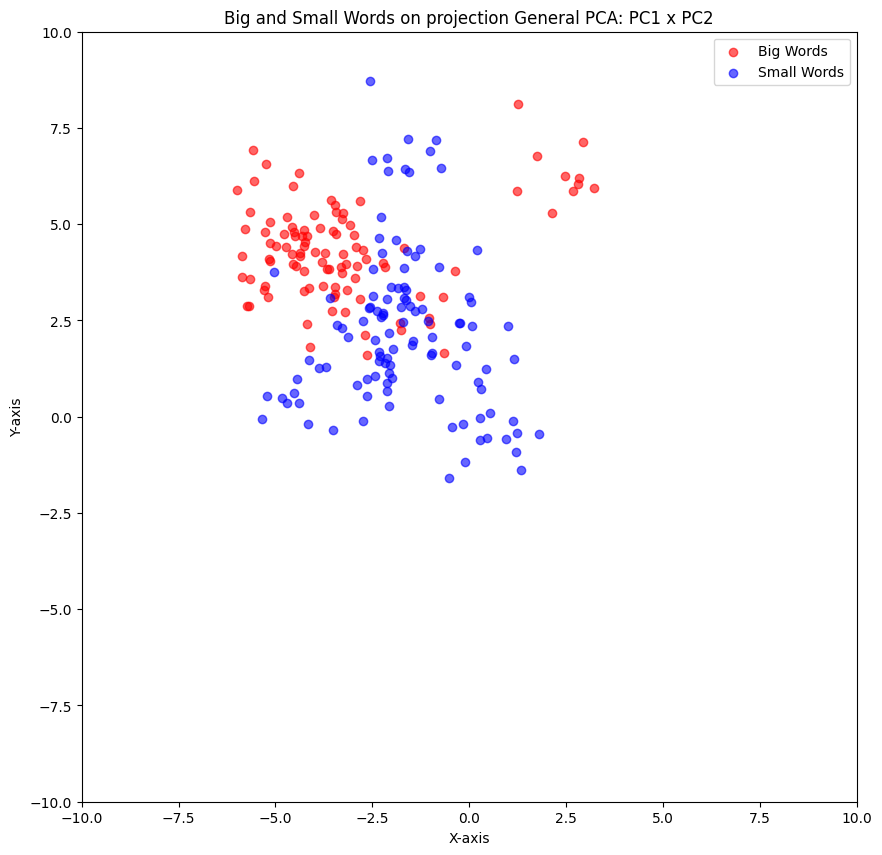

In [19]:
import importlib
import big_small_lib
importlib.reload(big_small_lib)
litmus_tester = big_small_lib.BigSmallLitmusTester(tokenizer="gpt2", debug=False)
litmus_tester.get_and_plot_2d_projections(
    model, pca_projector, "blocks.6.hook_resid_pre", projection_name="General PCA: PC1 x PC2"
)
